# Total Dataset mining

In [1]:
import pandas as pd 
import numpy as np
from datetime import date,datetime
import csv
import re
from multiprocessing import Pool
from functools import partial
from sklearn import preprocessing
from IPython.core import display as ICD
import matplotlib.pyplot as plt
import itertools
import os
import json
from dateutil.relativedelta import relativedelta
from sklearn import preprocessing

In [5]:
# TODO add doc 
def dataset_property_split(df,frequency,properties,min_support,groupby_property="CUST_ID",itemset_property="ARTICLE_ID",temp_folder="../lcm_temp",indexation_folder="../index"):
    """Split dataset """
    for period,i in df.groupby(pd.Grouper(freq = frequency)):
        for values,ii in i.groupby(properties):
            if len(properties)>1:
                values = '_'.join(str(z) for z in values)
            
            split_name = f"{temp_folder}/{period}_{values}#{min_support}"
            index_file_name = f"{indexation_folder}/{period}_{values}#{min_support}"

            ii = ii.groupby(groupby_property)[itemset_property].apply(lambda x: " ".join(str(z) for z in x))
            
            ii.to_csv(split_name,index=None,header=False)
            pd.DataFrame(ii.index).to_csv(index_file_name,header=False,index=None)
            yield str(split_name)
        

def preprocessing_similar_ids(df,mapping_file_path="../datasets/Total/ids_mapping.json",attribute_name="ARTICLE_ID"):
    with open(mapping_file_path,"r") as f:
        mapping = json.load(f)
        ids = df[attribute_name].astype(str).replace(mapping)
    return ids
def reformat_output(unformated_result,split_name,index_folder="../index"):
    """
    Reformat default output of lcm  to a dataframe with structure : min_support,itemsets,users
    """
    output = pd.DataFrame([unformated_result[0::2],unformated_result[1::2]]).T
    output = pd.concat([output.drop(0,axis=1),output[0].str.split('\(([0-9]+)\)',expand=True).drop(0,axis=1)],axis=1)
    split_name= split_name.split("/")[2] #remove temp folder from name
    output["period"] = split_name.split("_")[0]
    output["property_values"] = "_".join(split_name.split("_")[1:]).split("#")[0]
    output.columns = ["CUST_ID","support","itemset","period","property_values"]
    indexes = pd.read_csv(f'{index_folder}/{split_name}',header=None)[0].to_dict()
    output["CUST_ID"]= output["CUST_ID"].map(lambda x : [indexes[int(i)] for i in x.split()])
    return output


# TODO doc for support
def run_lcm(split_name,itemsets_size,support,output_file):
    """Runs LCM (Single Thread)  and return the  result formated with format_output
    
    Example for parameters : input_file='1999',support=6, itemsets_size=[5,100]
    Executed command :  $ ./lcm C_QI -l 5 -u 100 1999 6 -
    
    Preconfigured parameters:  
     C: enumerate closed frequent itemsets
     M: enumerate maximal frequent itemsets 
     Q: output the frequency on the head of each itemset found,
     I: output ID's of transactions including each itemset; ID of a transaction is given by the number of line in which the transaction is written. The ID starts from 0.
     _: no output to standard output (including messages w.r.t. input data)
     -l,-u [num]: enumerate itemsets with size at least/most [num]  
   
    Output:
        Replace file having name input_file with the result : support,itemset,users
        if no itemset found the input_file is deleted and output is empty string ""
    """
    support = int(support)
    result = !./lcm C_QI -l {itemsets_size[0]} -u {itemsets_size[1]}  {split_name} {support} -
    os.remove(split_name)
    if "there is no frequent item" in str(result) or result == []:
        print("No itemset",split_name)
        return 
    print("Found ",len(result)/2," in",split_name )
    # TODO Optimize this bottleneck 
    with open(output_file,"a") as file:
        reformat_output(result,split_name).to_csv(file,header=False,index=None,mode="a")
    return split_name


def multithread_lcm(input_file,frequency,support,itemsets_size,properties,output_file):
    f = partial(run_lcm,itemsets_size=itemsets_size,support=support, output_file=output_file)
    p = Pool(8)
    res  = p.imap_unordered(f,dataset_property_split(input_file,frequency,properties,support))
    p.close()
    p.join()
    return res
                                              
def linear_closed_itemset_miner(df,frequency,min_support,itemsets_size,properties):
    output_file = f'lcm_results/{frequency}-{min_support}-[{itemsets_size[0]}-{itemsets_size[1]}]-[{",".join(str(i) for i in properties)}]-lcm.out'
    os.remove(output_file) # In case already existing
    a = multithread_lcm(df,frequency,min_support,itemsets_size,properties,output_file)
    total  = len(a._items)
    print(a,total)
    a = [i for i in a if i is not None]
    print(f"---| {output_file} Done")
    print(f'---| #split total: {total}')
    print(f'---| #split having groups: {len(a)}')
    print(f'---| Average: {len(a)/total}')
    print(" ")
    
    
def age_class(age):
    """User age to range classes """
    age = np.int(age)
    if age<=25:
        return 0
    if age<=45:
        return 1
    return 2
def prepare_data(file_name,folder_name="datasets/Total/data/"):
    df = pd.read_csv(f"datasets/Total/data/{file_name}",sep=";")
    df_users = pd.read_csv("datasets/Total/users.csv",sep=";")
    df = df.merge(df_users,on="CUST_ID")
    df.index = pd.to_datetime(df.TRANSACTION_DATE).dt.to_period("D")
    return df

### Run LCM

In [ ]:
frequencies =["M","2M","3M"]
properties = [["STATION_MGT_TYPE"],["STATION_MGT_TYPE","DEPARTEMENT"]]
from itertools import product
for frequency,prop in product(frequencies,properties):
    linear_closed_itemset_miner(df,frequency,5,[2,"5000"],prop)

# LCM on promotion periods

In [3]:
import datetime
def concat_total_dataset(files_path='../datasets/Total/data'):
    df = pd.DataFrame()
    a = !ls {files_path}
    for i in a:
        df = pd.concat([pd.read_csv(f"../datasets/Total/data/{i}",sep=";"),df])
    df_users = pd.read_csv("../datasets/Total/users.csv",sep=";")
    df = df.merge(df_users,on="CUST_ID")
    df.index = pd.to_datetime(df.TRANSACTION_DATE).dt.to_period("D")
    df["STATION_DEPARTEMENT_ID"] = df.STATION_ID.apply(lambda x : x[3:5])
    df = df[df.STATION_DEPARTEMENT_ID==df.DEPARTEMENT]
    stations = pd.read_csv("../datasets/Total/STATION_TYPE.csv",sep=";")
    df = df.merge(stations,on="STATION_ID").dropna()
    df.index = pd.to_datetime(df.TRANSACTION_DATE).dt.to_period("D")
    df['date'] = pd.to_datetime(df.TRANSACTION_DATE)
    return df

In [6]:
df = concat_total_dataset()
df.ARTICLE_ID = preprocessing_similar_ids(df)


In [9]:
# Global parameters
frequency ="9M"
min_support= 5
itemsets_size = [1,"2001"]
properties = ["a"]
file_name =f'{frequency}-{min_support}-[{itemsets_size[0]}-{itemsets_size[1]}]-[{",".join(str(i) for i in properties)}]-lcm.out'
output_file = f'../lcm_results/{file_name}'

In [10]:
# Encoding for ARTICLE_ID as their size is not supported by current lcm implementation 
le = preprocessing.LabelEncoder()
le.fit(df["ARTICLE_ID"])
# # Encoder is saved 
np.save(f'../plots/encoders/{file_name}.npy', le.classes_)

In [11]:
# Promotion product list 
promo_products = pd.read_csv("../datasets/Total/promo_products.csv").drop_duplicates(subset=["id"])
promo_products= promo_products[promo_products["id"].isin(df.ARTICLE_ID)]
promo_list = le.transform([i for i in promo_products.id.tolist()])

In [12]:
df["ARTICLE_ID"] = le.transform(df["ARTICLE_ID"])

In [13]:
# promo dates 
promo_date_begin = pd.to_datetime(datetime.date(2018,12,17))
promo_date_end = pd.to_datetime(datetime.date(2019,2,28))


# Transactions data for T-1, T and T+1
# T-1 = [promo_date_begin - 3 months , promo_date_begin] 
df_promo_before = df[(df['date']< promo_date_begin)& (df['date']>promo_date_begin + relativedelta(months=-3))]

# T = [promo_date_begin , promo_date_end] 
# Only promotion products are considered in T
df_promo = df[(df.date>= promo_date_begin)& (df.date<=promo_date_end)]
df_promo = df_promo[df_promo.ARTICLE_ID.isin(promo_list)]

# T+1 = [promo_date_end , promo_date_end + 3 months] 
df_promo_after = df[(df.date> promo_date_end)& (df.date<=promo_date_end + relativedelta(months=3))]

In [14]:
print(f"#trsansaction : \n Before promo {df_promo_before.shape[0]} \n During promo {df_promo.shape[0]} \n After promo {df_promo_after.shape[0]} " )

#trsansaction : 
 Before promo 19463 
 During promo 705 
 After promo 19980 


# Run LCM 

In [15]:
os.remove(output_file)
f = partial(run_lcm,itemsets_size=itemsets_size,support=min_support, output_file=output_file)
for input_file in [df_promo_before,df_promo,df_promo_after]:
    input_file["a"]=1
    p = Pool(8)
    res  = p.imap_unordered(f,dataset_property_split(input_file,frequency,properties,min_support))
    p.close()
    p.join()

/home/abdelouahab/3env/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Found  771.0  in ../lcm_temp/2018-09_1#5
Found  6.0  in ../lcm_temp/2018-12_1#5
Found  785.0  in ../lcm_temp/2019-02_1#5


# Promo period stats

In [60]:
stats_df = all_promo.merge(promo_products,left_on="ARTICLE_ID",right_on="id")
stats_2 = stats_df.groupby("name")["name"].value_counts().to_frame().join(stats_df.groupby("name")["CUST_ID"].nunique())
stats_2.columns = ["frequency","distinct_users"]
stats_2

IndexError: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 1

IndexError: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 1

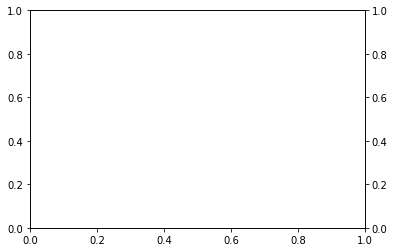

In [59]:
df.TRANSACTION_DATE = pd.to_datetime(df.TRANSACTION_DATE)
all_promo = df[(df.TRANSACTION_DATE>=promo_date_begin)&(df.TRANSACTION_DATE<= promo_date_end)]

import matplotlib.pyplot as plt 

fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4
stats_df.groupby("name")["name"].value_counts().plot.bar(figsize=(20,5),ax=ax, position=1)
stats_df.groupby("name")["CUST_ID"].nunique().plot.bar(color='red',ax=ax2, width=width, position=0)

# df.price.plot(kind='bar', color='blue', )

ax.set_ylabel('frequency')
ax2.set_ylabel('distinct_users')

plt.show()

In [38]:
users_stats = stats_df.groupby("CUST_ID")["name"].unique().to_frame()
users_stats["count"] = users_stats.apply(lambda x : len(x["name"]),axis=1)
users_stats.sort_values("count",ascending=False).head(10)

,name,count
CUST_ID,,
572727,"[TOTAL QUARTZ INEO LONG LIFE 5W30 1L, TOTAL AD...",3
749584,"[EVIAN 50CL, ADBLUE 10L, TOTAL ADBLUE BIDON 10L]",3
444175,"[TOTAL ADBLUE 10L, ADBLUE 10L]",2
794248,"[EVIAN 50CL, TOTAL QUARTZ INEO LONG LIFE 5W30 1L]",2
145422,"[EVIAN 50CL, CR EVIAN PET 50CL]",2
575459,"[CR EVIAN PET 50CL, Lun Evian Pet 50Cl]",2
301402,"[TOTAL ADBLUE 10L, ADBLUE 10L]",2
409352,"[ADBLUE 10L, TOTAL QUARTZ 90]",2
955120,"[ADBLUE 10L, TOTAL ADBLUE BIDON 10L]",2


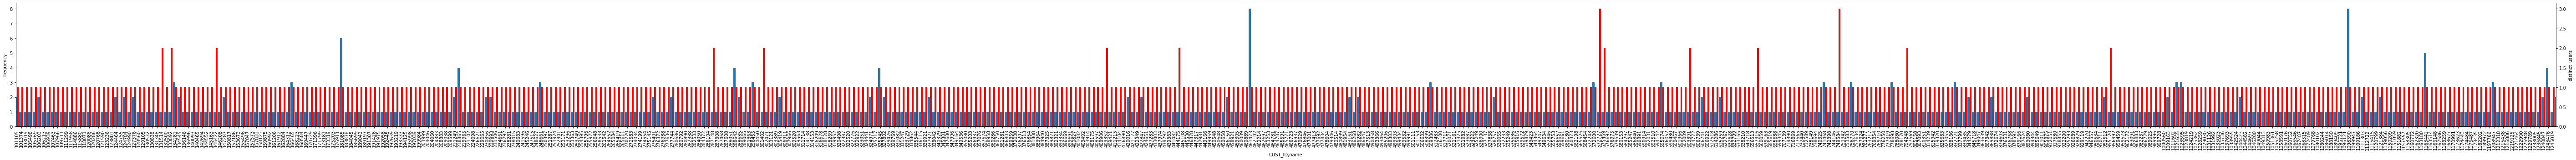

In [17]:
fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4
stats_df.groupby("CUST_ID")["name"].value_counts().plot.bar(figsize=(100,5),ax=ax, position=1)
stats_df.groupby("CUST_ID")["name"].nunique().plot.bar(color='red',ax=ax2, width=width, position=0)

# df.price.plot(kind='bar', color='blue', )

ax.set_ylabel('frequency')
ax2.set_ylabel('distinct_users')

plt.show()

In [37]:
df_promo

,TRANS_ID,TRANSACTION_DATE,STATION_ID,CUST_ID,ARTICLE_ID,TTC_PRICE,SEX,AGE,DEPARTEMENT,STATION_DEPARTEMENT_ID,STATION_MGT_TYPE,date
TRANSACTION_DATE,,,,,,,,,,,,
2018-12-23,NF0062749800403181223185436,2018-12-23 18:55:23,NF006274,757924,3068320099651,1,M,35-49,06,06,CODO,2018-12-23 18:55:23
2019-01-29,NF0062741147913190129162159,2019-01-29 16:21:59,NF006274,528757,3217770310902,"18,5",M,50-65,06,06,CODO,2019-01-29 16:21:59
2019-02-01,NF0062741149089190201200156,2019-02-01 20:01:56,NF006274,275145,3068320099651,1,F,35-49,06,06,CODO,2019-02-01 20:01:56
2018-12-18,NF0062741132356181218101759,2018-12-18 10:17:59,NF006274,657916,3068320099651,1,M,35-49,06,06,CODO,2018-12-18 10:17:59
2019-02-07,NF0062741151173190207174307,2019-02-07 17:43:07,NF006274,657916,3217770310902,"18,5",M,35-49,06,06,CODO,2019-02-07 17:43:07
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-24,NF0596291114628190124073305,2019-01-24 07:33:05,NF059629,543423,3701239300011,"19,95",M,35-49,59,59,CODO,2019-01-24 07:33:05
2019-01-26,NF0781431120215190126085207,2019-01-26 08:52:07,NF078143,732440,3011441109006,"17,95",M,35-49,78,78,CODO,2019-01-26 08:52:07
2018-12-20,NF0706611168170181220091032,2018-12-20 09:10:32,NF070661,1225948,3217770310902,14,M,<35,70,70,DODO,2018-12-20 09:10:32


### Draft

In [132]:
promo_stats = df_promo.groupby("CUST_ID")["ARTICLE_ID"].apply(set).to_frame().sort_values("ARTICLE_ID",ascending=False)
promo_products

,id,name
0,2715,BIDON AD BLUE 10L
1,2716,ADBLUE BIDON 5L
6,2133,TOTAL ADBLUE BIDON 10L
7,4077,TOTAL ADBLUE BIDON 10L
13,4759,TOTAL ADBLUE BIDON 10L
14,2094,ADBLUE 10L
23,3628,ADBLUE 10L AD
37,3498,ELF EVOLUTION 5W30 2 L
46,3489,ELF MOTO 2 OFF ROAD 1L 10W40 SAE 30
49,2158,ELF POLISH MOTO 400ML


In [18]:
df.head()

,TRANS_ID,TRANSACTION_DATE,STATION_ID,CUST_ID,ARTICLE_ID,TTC_PRICE,SEX,AGE,DEPARTEMENT,STATION_DEPARTEMENT_ID,STATION_MGT_TYPE,date
TRANSACTION_DATE,,,,,,,,,,,,
2017-10-27,NF0591901710311171027214705,2017-10-27 21:47:05,NF059190,271364,16070,"1,5",M,35-49,59,59,COCO,2017-10-27 21:47:05
2017-11-03,NF0591906100106171103195742,2017-11-03 20:10:58,NF059190,600388,3242272845355,"4,95",M,35-49,59,59,COCO,2017-11-03 20:10:58
2017-11-03,NF0591906100106171103195742,2017-11-03 20:10:58,NF059190,600388,3242272845256,"4,95",M,35-49,59,59,COCO,2017-11-03 20:10:58
2017-11-03,NF0591906100106171103195742,2017-11-03 20:10:58,NF059190,600388,7622300292508,"3,95",M,35-49,59,59,COCO,2017-11-03 20:10:58
2017-11-03,NF0591906100106171103195742,2017-11-03 20:10:58,NF059190,600388,3124480100016,"3,1",M,35-49,59,59,COCO,2017-11-03 20:10:58


In [21]:
new = df.ARTICLE_ID.astype(str).replace(mapping)

In [79]:
df.ARTICLE_ID.nunique(),df.ARTICLE_ID.nunique()

(7641, 7641)

In [84]:
df.ARTICLE_ID.nunique(),df.ARTICLE_ID.nunique()

(7641, 7641)

In [176]:
promo_products = pd.read_csv('../datasets/Total/promo_products.csv')

In [180]:
(promo_products["id"]!= preprocessing_similar_ids(promo_products,attribute_name="id")).sum()

0

In [187]:
prom_products.drop_duplicates(subset='id').drop_duplicates(subset='name').shape

(53, 2)